 ## Что можно показать в skimage? 



Официальная страница skiimage с примерами:
https://scikit-image.org/docs/stable/auto_examples/ 
Некоторые из них я покажу вам здесь



In [1]:
# выгрузим все необходимые библиотеки сразу по PEP-8
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from matplotlib.colors import LinearSegmentedColormap
from skimage import (
    data, color, draw, exposure, 
    feature, img_as_float, 
    img_as_ubyte, transform
)
from skimage.color import rgb2gray, rgb2hsv, rgb2hed
from skimage.exposure import match_histograms

### Цветовые модели и работа с цветом

Так же, как в OpenCV, можно переходить к разным цветовым моделям.

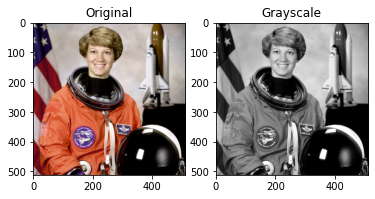

In [2]:
original = data.astronaut()
grayscale = rgb2gray(original)

plt.subplot(121)
plt.imshow(original)
plt.title("Original")
plt.subplot(122)
plt.imshow(grayscale, cmap=plt.cm.gray)
plt.title("Grayscale")
plt.show()

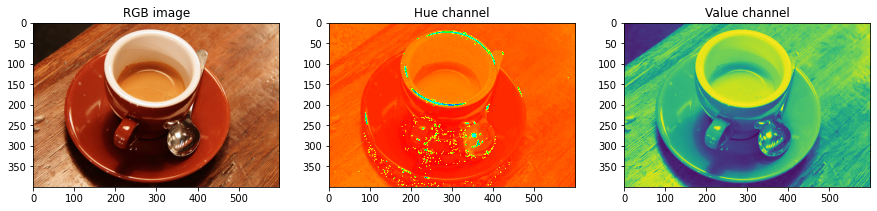

In [3]:
rgb_img = data.coffee()
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(rgb_img)
plt.title("RGB image")
plt.subplot(132)
plt.imshow(hue_img, cmap='hsv')
plt.title("Hue channel")
plt.subplot(133)
plt.imshow(value_img)
plt.title("Value channel")

plt.show()

Можно выделить предмет на изображние, поставив threshold на цветовой фон:

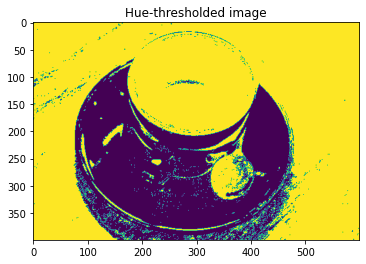

In [4]:
hue_threshold = 0.04
binary_img = hue_img > hue_threshold

plt.imshow(binary_img)
plt.title("Hue-thresholded image")

plt.show()

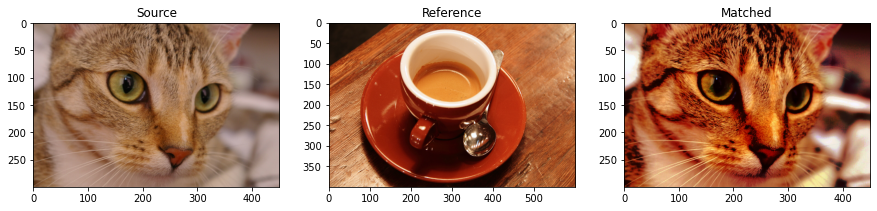

In [5]:
reference = data.coffee()
image = data.chelsea()

matched = match_histograms(image, reference, multichannel=True)

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(image)
plt.title('Source')
plt.subplot(132)
plt.imshow(reference)
plt.title('Reference')
plt.subplot(133)
plt.imshow(matched)
plt.title('Matched')

plt.show()

Тут же можно разделить различные типы тканей на изображении:

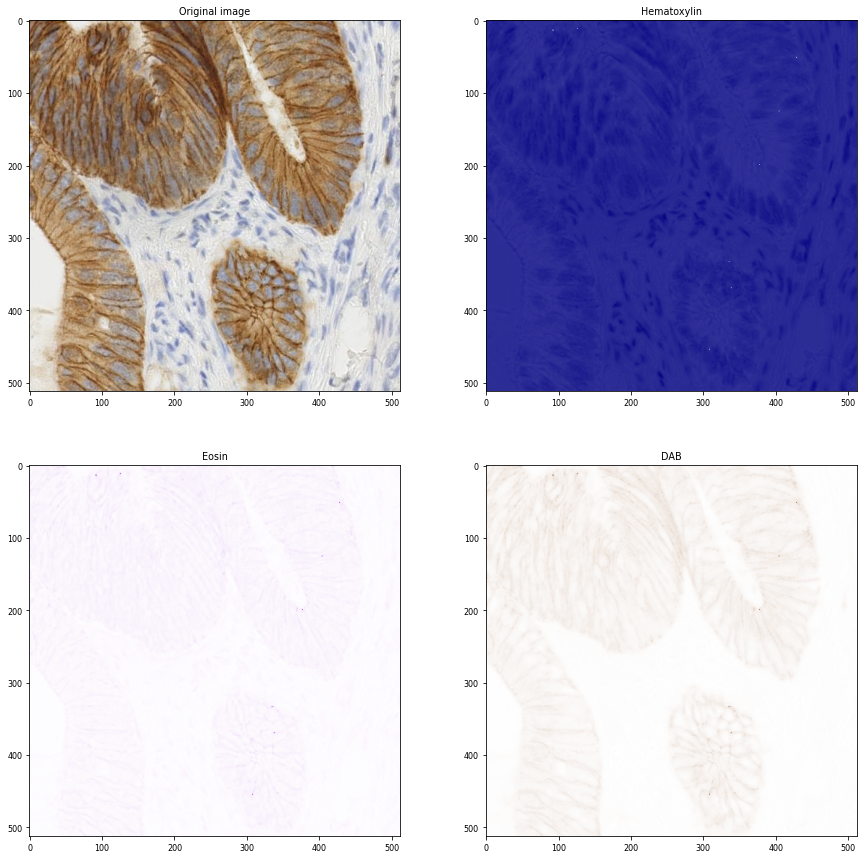

In [6]:
matplotlib.rcParams['font.size'] = 8

# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list(
    'mycmap', ['white', 'navy']
)
cmap_dab = LinearSegmentedColormap.from_list(
    'mycmap', ['white', 'saddlebrown']
)
cmap_eosin = LinearSegmentedColormap.from_list(
    'mycmap', ['darkviolet', 'white']
)

ihc_rgb = data.immunohistochemistry()
ihc_hed = rgb2hed(ihc_rgb)

plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(ihc_rgb)
plt.title("Original image")

plt.subplot(222)
plt.imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
plt.title("Hematoxylin")

plt.subplot(223)
plt.imshow(ihc_hed[:, :, 1], cmap=cmap_eosin)
plt.title("Eosin")

plt.subplot(224)
plt.imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
plt.title("DAB")


plt.show()

## Улучшение контрастности

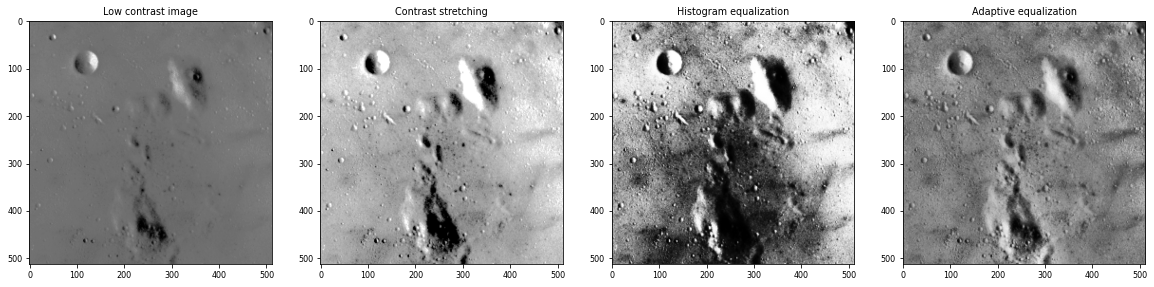

In [7]:
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
plt.figure(figsize=(20,10))

plt.subplot(141)
plt.imshow(img, cmap=plt.cm.gray)
plt.title('Low contrast image')

plt.subplot(142)
plt.imshow(img_rescale, cmap=plt.cm.gray)
plt.title('Contrast stretching')

plt.subplot(143)
plt.imshow(img_eq, cmap=plt.cm.gray)
plt.title('Histogram equalization')

plt.subplot(144)
plt.imshow(img_adapteq, cmap=plt.cm.gray)
plt.title('Adaptive equalization')

plt.show()

## Детектор границ

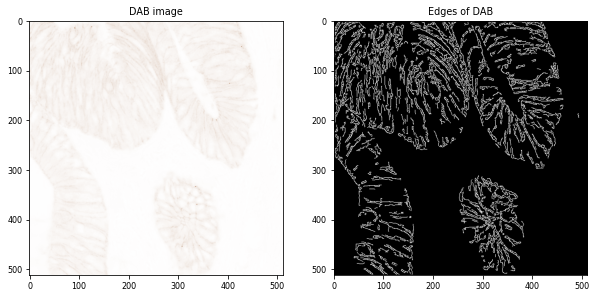

In [8]:
edges_dab = feature.canny(ihc_hed[:, :, 2], sigma=0.4)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ihc_hed[:, :, 2], cmap_dab)
plt.title('DAB image')
plt.subplot(122)
plt.imshow(edges_dab, cmap=plt.cm.gray)
plt.title('Edges of DAB')
plt.show()

Таким образом можно подготовить датасет для задачи сегментации. Осталось только сохранить изображение с помощью matplotlib.

In [9]:
plt.imsave('mask_image.jpg', edges_dab)

# Задание 1
С помощью Canny edge detector найдите эллипс по цветовому градиенту между красным и белым (задача на погуглить, советую проштудировать галерею skimage). Результатом должна быть маска эллипса на изображении. Подайте ее на вход тестовой функции)

In [10]:
image_rgb = data.coffee()[0:220, 160:420]

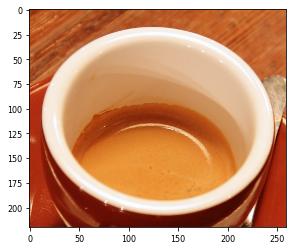

In [11]:
plt.imshow(image_rgb)

In [12]:
image_gray = color.rgb2gray(image_rgb)
edges = feature.canny(
    image_gray, sigma=2.0, low_threshold=0.55, high_threshold=0.8
)

In [13]:
result = transform.hough_ellipse(
    edges, accuracy=20, threshold=250, min_size=100, max_size=120
)
result.sort(order='accumulator')
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]

orientation = best[5]
cy, cx = draw.ellipse_perimeter(yc, xc, a, b, orientation)

mask = np.zeros((edges.shape))
mask = color.gray2rgb(img_as_ubyte(mask))
mask[cy, cx] = (250, 0, 0)
mask = color.rgb2gray(img_as_ubyte(mask))
mask[mask>0]=1

print(np.sum((mask == 1) & edges))    

# Задание 2
Восстановите яркость темного изображения Меган Фокс по референсной картинке

In [14]:
megan = skimage.io.imread('megan.jpeg')
dark_megan =  skimage.io.imread('dark_megan.jpeg')

In [15]:
matched = match_histograms(dark_megan, megan, multichannel=True)
np.sum(np.isclose(matched, megan, atol=0.1))
#сделайте +- 50